
Test 1: Linear Simple
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.002414
Accuracy: 100.0%
PMC (2, 2, 1) : OK


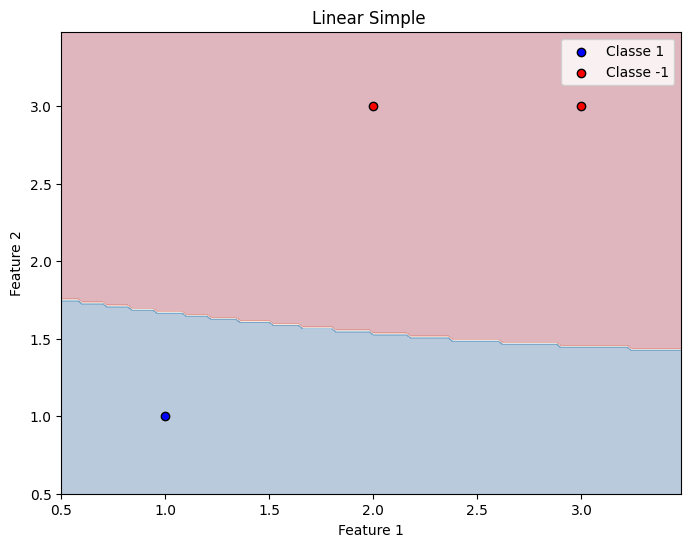


Test 2: Linear Multiple
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.903291
Accuracy: 50.0%
PMC (2, 2, 1) : KO


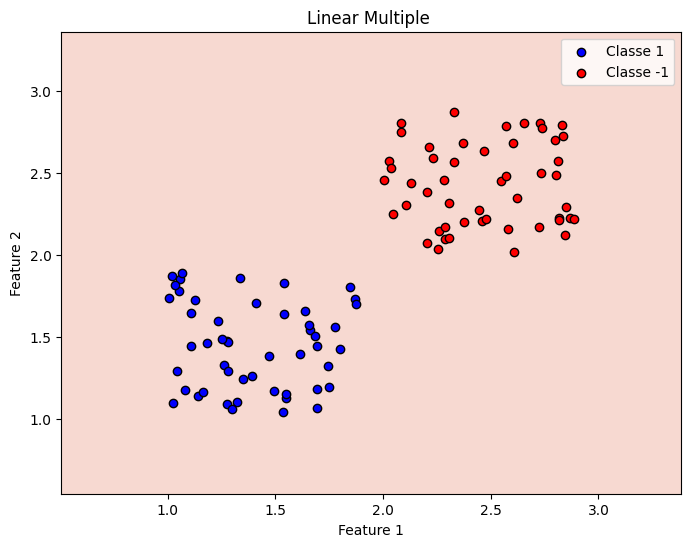


Test 3: XOR
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.680433
Accuracy: 75.0%
PMC (2, 2, 1) : KO


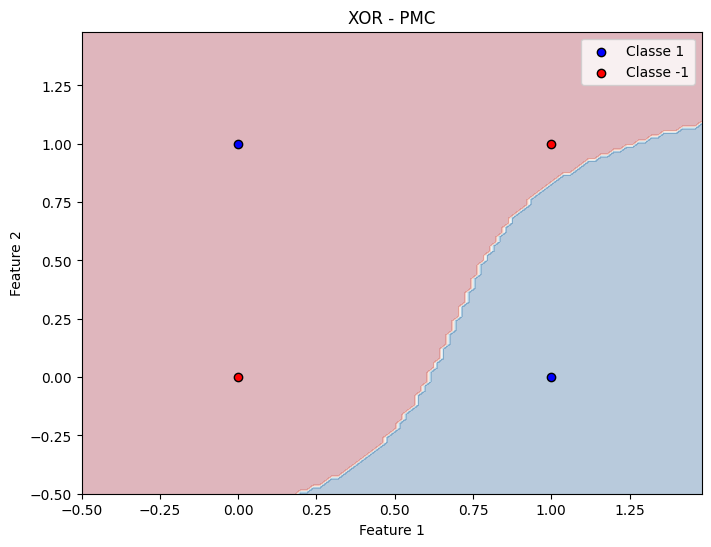


Test 4: Cross
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.709597
Accuracy: 73.8%
PMC (2, 4, 1) : KO


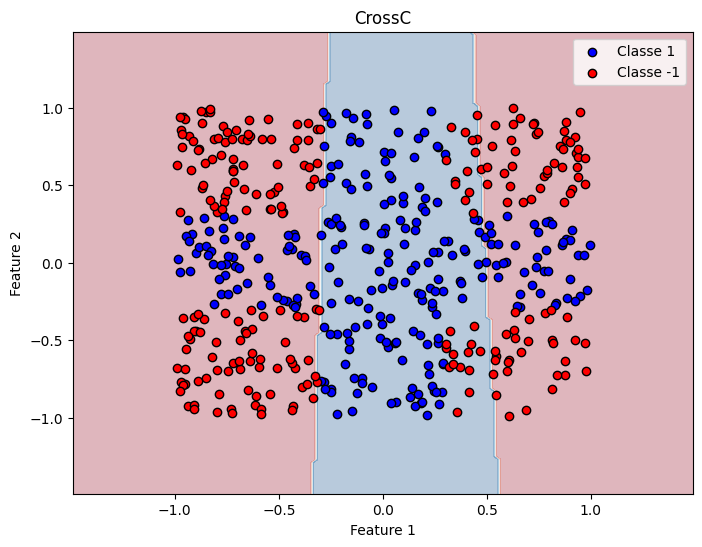


Test 5: Multi Linear 3 classes 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.226752
Accuracy: 30.2%
PMC (2, 3, 3) : KO


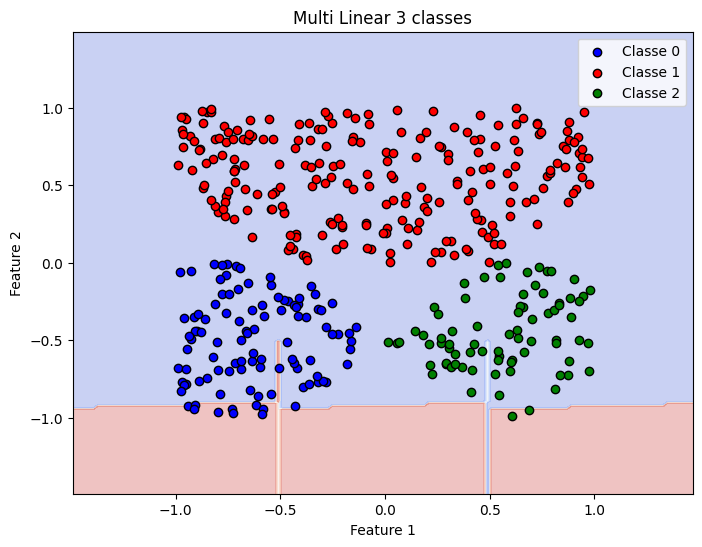


Test 6: Multi Cross - PMC
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.237319
Accuracy: 29.3%
PMC (2, 8, 3) : KO


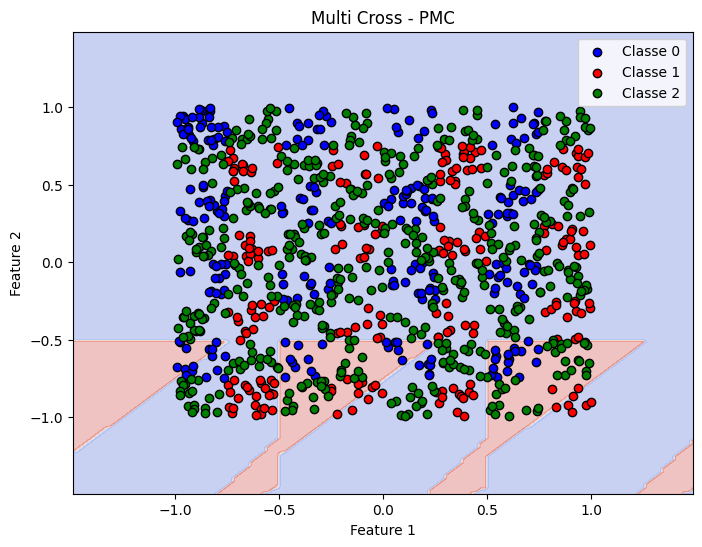


Test 7: Régression - Linear Simple 2D
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 2.500000
MSE: 2.500000
Prédictions sur nouvelles données: [1. 1.]
PMC (1, 2, 1) : KO


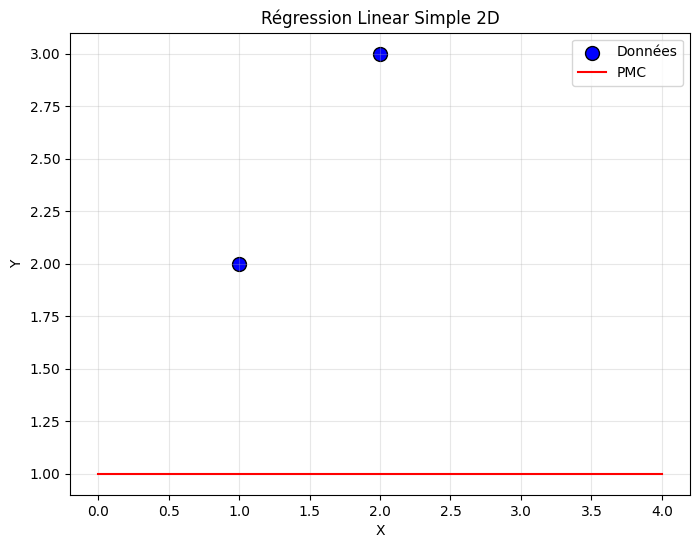


Test 8: Régression - Non Linear Simple 2D 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 2.416667
MSE: 2.416667
PMC (1, 4, 1) : KO


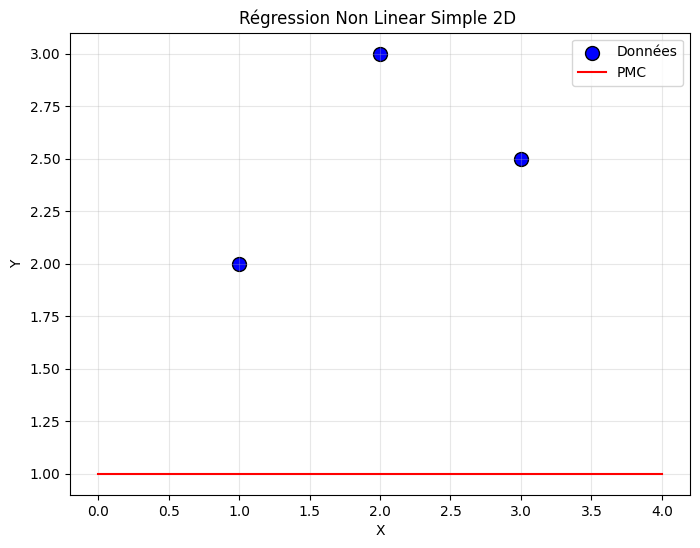


Test 9: Régression - Linear Simple 3D 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 2.416667
MSE: 2.416667
PMC (2, 2, 1) : KO


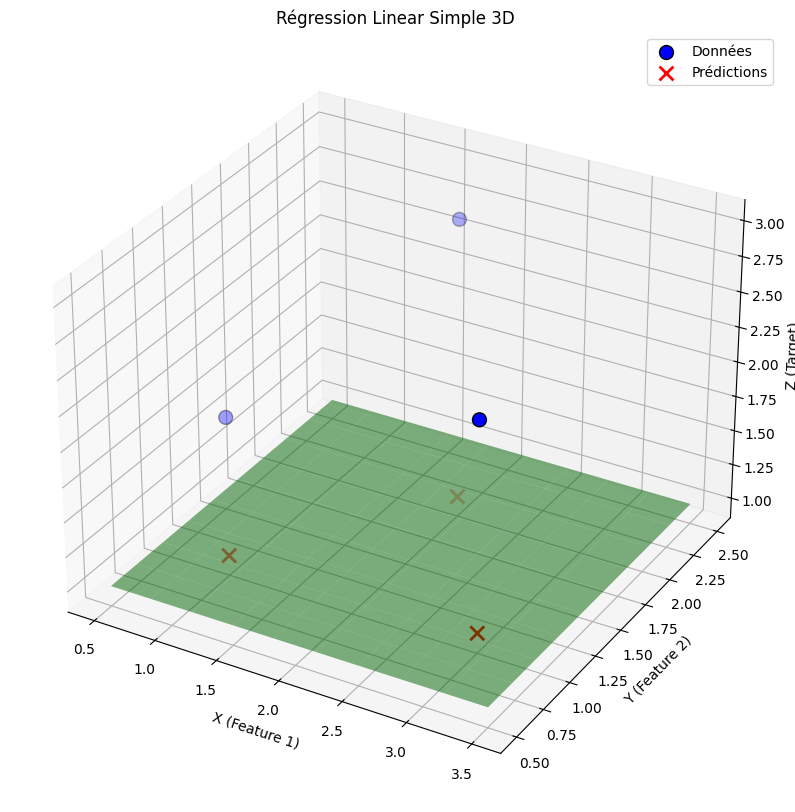


Test 10: Linear Tricky 3D
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 1.666667
MSE: 1.666667
PMC (2, 2, 1) : KO


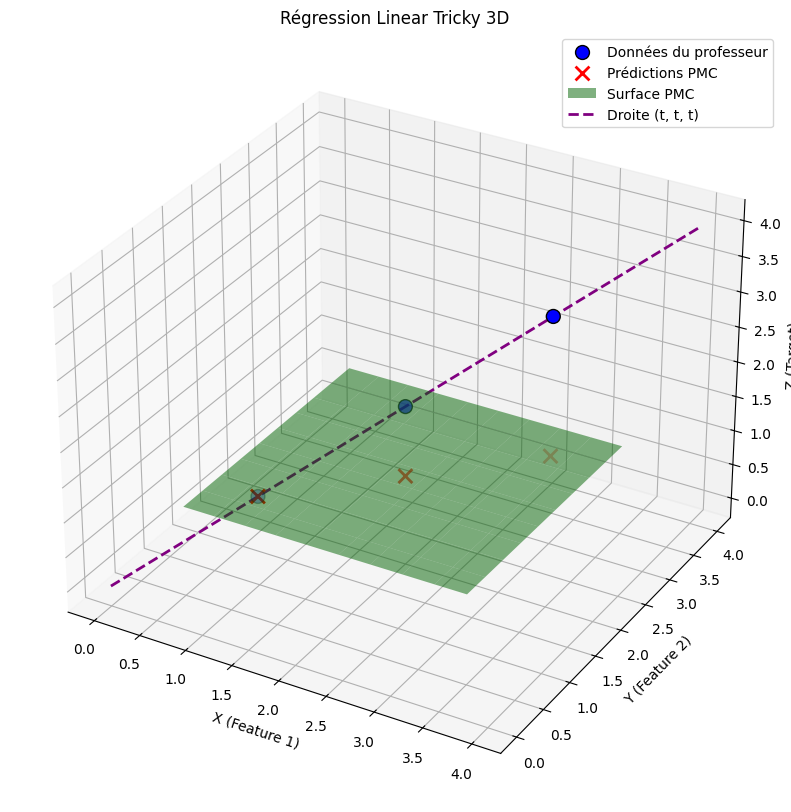


Analyse de la performance:
Valeurs réelles: [1. 2. 3.]
Prédictions: [1. 1. 1.]
Différences: [0. 1. 2.]
Nouvelles entrées X: [[1.5 1.5]
 [2.5 2.5]
 [0.5 0.5]]
Prédictions: [1. 1. 1.]
Valeurs attendues (sur la droite): [1.5 2.5 0.5]

Test 11: Régression - Non Linear Simple 3D 
Chargement de: ./target/release/neural_networks.dll
Erreur après entraînement: 0.542070
MSE: 0.642606
PMC (2, 4, 1) : KO


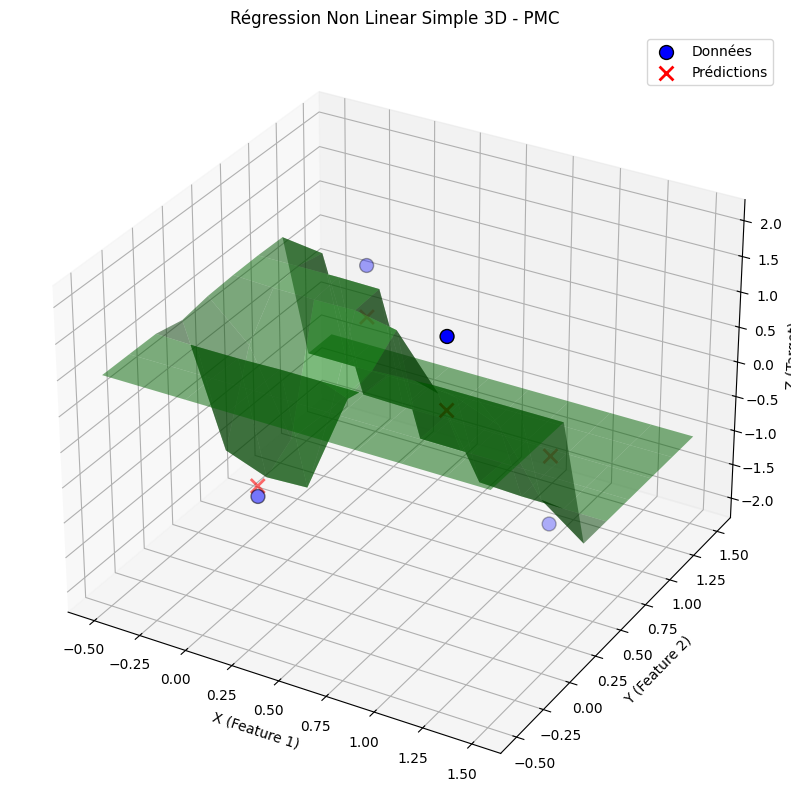

In [4]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class PMCConfig(ctypes.Structure):
    _fields_ = [
        ("n_inputs", ctypes.c_uint),
        ("n_hidden", ctypes.c_uint),
        ("n_outputs", ctypes.c_uint),
        ("learning_rate", ctypes.c_double)
    ]

class PMC:
    def __init__(self, n_inputs, n_hidden, n_outputs=1, learning_rate=0.01):
        dll_path = "./target/release/neural_networks.dll"
        
        print(f"Chargement de: {dll_path}")
        self.lib = ctypes.CDLL(dll_path)
        
        # Définir les types d'arguments pour les fonctions PMC
        self.lib.pmc_new.argtypes = [ctypes.POINTER(PMCConfig)]
        self.lib.pmc_new.restype = ctypes.c_void_p
        
        self.lib.pmc_delete.argtypes = [ctypes.c_void_p]
        
        self.lib.pmc_fit.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        self.lib.pmc_fit.restype = ctypes.c_double
        
        self.lib.pmc_predict_batch.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        
        self.lib.pmc_accuracy.argtypes = [
            ctypes.c_void_p,
            ctypes.POINTER(ctypes.c_double),
            ctypes.POINTER(ctypes.c_double),
            ctypes.c_size_t,
            ctypes.c_size_t
        ]
        self.lib.pmc_accuracy.restype = ctypes.c_double
        
      
        self.config = PMCConfig(
            n_inputs=n_inputs,
            n_hidden=n_hidden,
            n_outputs=n_outputs,
            learning_rate=learning_rate
        )
        
  
        self.ptr = self.lib.pmc_new(ctypes.byref(self.config))
        if not self.ptr:
            raise RuntimeError("Échec de création du modèle PMC")
        
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
    
    def __del__(self):
        if hasattr(self, 'ptr') and self.ptr:
            self.lib.pmc_delete(self.ptr)
    
    def fit(self, X, y, max_iterations=1000):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        y_flat = y.astype(np.float64).flatten()
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        error = self.lib.pmc_fit(
            self.ptr, X_ptr, y_ptr, 
            n_samples, n_features, max_iterations
        )
        
        return error
    
    def predict(self, X):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        
        if self.n_outputs == 1:
            results = np.zeros(n_samples, dtype=np.float64)
        else:
            results = np.zeros(n_samples * self.n_outputs, dtype=np.float64)
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        results_ptr = results.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        self.lib.pmc_predict_batch(self.ptr, X_ptr, results_ptr, n_samples, n_features)
        
        if self.n_outputs > 1:
            results = results.reshape(n_samples, self.n_outputs)
        
        return results
    
    def predict_class(self, X, threshold=0.0):
        predictions = self.predict(X)
        if self.n_outputs == 1:
            return np.where(predictions >= threshold, 1, -1)
        else:
            if len(predictions.shape) == 2:
                return np.argmax(predictions, axis=1)
            else:
                return predictions
    
    def accuracy(self, X, y):
        n_samples, n_features = X.shape
        
        if n_features != self.n_inputs:
            raise ValueError(f"Attendu {self.n_inputs} features, reçu {n_features}")
        
        X_flat = X.astype(np.float64).flatten()
        y_flat = y.astype(np.float64).flatten()
        
        X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        y_ptr = y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
        
        return self.lib.pmc_accuracy(self.ptr, X_ptr, y_ptr, n_samples, n_features)

def visualiser_frontiere_decision(X, Y, model, titre, threshold=0.0):
    h = 0.02 
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict_class(np.c_[xx.ravel(), yy.ravel()], threshold)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    
    if model.n_outputs == 1:
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
        plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue', label='Classe 1', edgecolor='k')
        plt.scatter(X[Y == -1, 0], X[Y == -1, 1], color='red', label='Classe -1', edgecolor='k')
    else:
 
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        unique_classes = np.unique(Y)
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for i, cls in enumerate(unique_classes):
            if i < len(colors):
                plt.scatter(X[Y == cls, 0], X[Y == cls, 1], 
                           color=colors[i], label=f'Classe {int(cls)}', edgecolor='k')
    
    plt.title(titre)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()



# Test 1: Linear Simple
print("\nTest 1: Linear Simple")
X_simple = np.array([[1, 1], [2, 3], [3, 3]], dtype=np.float64)
Y_simple = np.array([1, -1, -1], dtype=np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_simple, Y_simple, max_iterations=1000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_simple)
predictions_class = np.where(predictions >= 0.0, 1, -1)
accuracy = np.mean(predictions_class == Y_simple)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("PMC (2, 2, 1) : OK")
else:
    print("PMC (2, 2, 1) : KO")

visualiser_frontiere_decision(X_simple, Y_simple, model_pmc, "Linear Simple ")

# Test 2: Linear Multiple 
print("\nTest 2: Linear Multiple")
np.random.seed(42) 
X_multiple = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([2, 2])
]).astype(np.float64)
Y_multiple = np.concatenate([
    np.ones((50, 1)),
    np.ones((50, 1)) * -1.0
]).astype(np.float64).flatten()

model_pmc = PMC(n_inputs=2, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_multiple, Y_multiple, max_iterations=1000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_multiple)
predictions_class = np.where(predictions >= 0.0, 1, -1)
accuracy = np.mean(predictions_class == Y_multiple)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.95:
    print("PMC (2, 2, 1) : OK")
else:
    print("PMC (2, 2, 1) : KO")

visualiser_frontiere_decision(X_multiple, Y_multiple, model_pmc, "Linear Multiple ")

# Test 3: XOR
print("\nTest 3: XOR")
X_xor = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype=np.float64)
Y_xor = np.array([1, 1, -1, -1], dtype=np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_xor, Y_xor, max_iterations=5000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_xor)
predictions_class = np.where(predictions >= 0.0, 1, -1)
accuracy = np.mean(predictions_class == Y_xor)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy == 1.0:
    print("PMC (2, 2, 1) : OK")
else:
    print("PMC (2, 2, 1) : KO")

visualiser_frontiere_decision(X_xor, Y_xor, model_pmc, "XOR - PMC")

# Test 4: Cross 
print("\nTest 4: Cross")
np.random.seed(42)  
X_cross = np.random.random((500, 2)) * 2.0 - 1.0
X_cross = X_cross.astype(np.float64)
Y_cross = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X_cross])
Y_cross = Y_cross.astype(np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=4, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_cross, Y_cross, max_iterations=2000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_cross)
predictions_class = np.where(predictions >= 0.0, 1, -1)
accuracy = np.mean(predictions_class == Y_cross)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.95:
    print("PMC (2, 4, 1) : OK")
else:
    print("PMC (2, 4, 1) : KO")

sample_indices = np.random.choice(len(X_cross), 100, replace=False)
X_sample = X_cross[sample_indices]
Y_sample = Y_cross[sample_indices]
visualiser_frontiere_decision(X_cross, Y_cross, model_pmc, "CrossC")

print("\nTest 5: Multi Linear 3 classes ")
np.random.seed(42) 
X_multi_linear = np.random.random((500, 2)) * 2.0 - 1.0

Y_multi_linear = np.array([
    [1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
    [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
    [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
    [-1, -1, -1] for p in X_multi_linear
])

mask = [not np.all(arr == [-1, -1, -1]) for arr in Y_multi_linear]
X_multi_linear = X_multi_linear[mask]
Y_multi_linear = Y_multi_linear[mask]

Y_multi_linear_classes = np.zeros(len(Y_multi_linear), dtype=np.float64)
Y_multi_linear_onehot = np.zeros((len(Y_multi_linear), 3), dtype=np.float64)
for i, y_vec in enumerate(Y_multi_linear):
    if y_vec[0] == 1:
        Y_multi_linear_classes[i] = 0
        Y_multi_linear_onehot[i] = [1, 0, 0]
    elif y_vec[1] == 1:
        Y_multi_linear_classes[i] = 1
        Y_multi_linear_onehot[i] = [0, 1, 0]
    elif y_vec[2] == 1:
        Y_multi_linear_classes[i] = 2
        Y_multi_linear_onehot[i] = [0, 0, 1]

model_pmc = PMC(n_inputs=2, n_hidden=3, n_outputs=3, learning_rate=0.01)

error = model_pmc.fit(X_multi_linear, Y_multi_linear_onehot, max_iterations=2000)
print(f"Erreur après entraînement: {error:.6f}")

predictions_raw = model_pmc.predict(X_multi_linear)
predictions_class = np.argmax(predictions_raw, axis=1)
accuracy = np.mean(predictions_class == Y_multi_linear_classes)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.95:
    print("PMC (2, 3, 3) : OK")
else:
    print("PMC (2, 3, 3) : KO")

visualiser_frontiere_decision(X_multi_linear, Y_multi_linear_classes, model_pmc, "Multi Linear 3 classes")


print("\nTest 6: Multi Cross - PMC")
np.random.seed(42) 
X_multi_cross = np.random.random((1000, 2)) * 2.0 - 1.0

Y_multi_cross = np.array([
    [1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
    [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
    [-1, -1, 1] for p in X_multi_cross
])

Y_multi_cross_classes = np.zeros(len(Y_multi_cross), dtype=np.float64)
Y_multi_cross_onehot = np.zeros((len(Y_multi_cross), 3), dtype=np.float64)
for i, y_vec in enumerate(Y_multi_cross):
    if y_vec[0] == 1:
        Y_multi_cross_classes[i] = 0
        Y_multi_cross_onehot[i] = [1, 0, 0]
    elif y_vec[1] == 1:
        Y_multi_cross_classes[i] = 1
        Y_multi_cross_onehot[i] = [0, 1, 0]
    elif y_vec[2] == 1:
        Y_multi_cross_classes[i] = 2
        Y_multi_cross_onehot[i] = [0, 0, 1]

model_pmc = PMC(n_inputs=2, n_hidden=8, n_outputs=3, learning_rate=0.01)
error = model_pmc.fit(X_multi_cross, Y_multi_cross_onehot, max_iterations=3000)
print(f"Erreur après entraînement: {error:.6f}")

predictions_raw = model_pmc.predict(X_multi_cross)
predictions_class = np.argmax(predictions_raw, axis=1)
accuracy = np.mean(predictions_class == Y_multi_cross_classes)
print(f"Accuracy: {accuracy * 100:.1f}%")

if accuracy > 0.90:
    print("PMC (2, 8, 3) : OK")
else:
    print("PMC (2, 8, 3) : KO")

visualiser_frontiere_decision(X_multi_cross, Y_multi_cross_classes, model_pmc, "Multi Cross - PMC")

# Test 7: Régression - Linear Simple 2D 
print("\nTest 7: Régression - Linear Simple 2D")
X_reg_simple = np.array([[1], [2]], dtype=np.float64)
Y_reg_simple = np.array([2, 3], dtype=np.float64)

model_pmc = PMC(n_inputs=1, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_reg_simple, Y_reg_simple, max_iterations=1000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_reg_simple)
mse = np.mean((Y_reg_simple - predictions) ** 2)
print(f"MSE: {mse:.6f}")

X_test = np.array([[0], [3]], dtype=np.float64)
predictions_test = model_pmc.predict(X_test)
print(f"Prédictions sur nouvelles données: {predictions_test}")

if mse < 0.01:
    print("PMC (1, 2, 1) : OK")
else:
    print("PMC (1, 2, 1) : KO")


plt.figure(figsize=(8, 6))
x_plot = np.linspace(0, 4, 100).reshape(-1, 1)
y_plot = model_pmc.predict(x_plot)
plt.scatter(X_reg_simple, Y_reg_simple, color='blue', s=100, edgecolor='k', label='Données')
plt.plot(x_plot, y_plot, color='red', label='PMC')
plt.title("Régression Linear Simple 2D")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test 8: Régression - Non Linear Simple 2D 
print("\nTest 8: Régression - Non Linear Simple 2D ")
X_nonlinear = np.array([[1], [2], [3]], dtype=np.float64)
Y_nonlinear = np.array([2, 3, 2.5], dtype=np.float64)

model_pmc = PMC(n_inputs=1, n_hidden=4, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_nonlinear, Y_nonlinear, max_iterations=3000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_nonlinear)
mse = np.mean((Y_nonlinear - predictions) ** 2)
print(f"MSE: {mse:.6f}")

if mse < 0.01:
    print("PMC (1, 4, 1) : OK")
else:
    print("PMC (1, 4, 1) : KO")

# Visualisation
plt.figure(figsize=(8, 6))
x_plot = np.linspace(0, 4, 100).reshape(-1, 1)
y_plot = model_pmc.predict(x_plot)
plt.scatter(X_nonlinear, Y_nonlinear, color='blue', s=100, edgecolor='k', label='Données')
plt.plot(x_plot, y_plot, color='red', label='PMC')
plt.title("Régression Non Linear Simple 2D ")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test 9: Régression - Linear Simple 3D
print("\nTest 9: Régression - Linear Simple 3D ")
X_3d_simple = np.array([[1, 1], [2, 2], [3, 1]], dtype=np.float64)
Y_3d_simple = np.array([2, 3, 2.5], dtype=np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_3d_simple, Y_3d_simple, max_iterations=1000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_3d_simple)
mse = np.mean((Y_3d_simple - predictions) ** 2)
print(f"MSE: {mse:.6f}")

if mse < 0.001:
    print("PMC (2, 2, 1) : OK")
else:
    print("PMC (2, 2, 1) : KO")


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3d_simple[:, 0], X_3d_simple[:, 1], Y_3d_simple, 
           color='blue', s=100, edgecolor='k', label='Données')

ax.scatter(X_3d_simple[:, 0], X_3d_simple[:, 1], predictions,
           color='red', s=100, marker='x', linewidth=2, label='Prédictions')

x_range = np.linspace(0.5, 3.5, 10)
y_range = np.linspace(0.5, 2.5, 10)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
Z_grid = model_pmc.predict(grid_points).reshape(X_grid.shape)

ax.plot_surface(X_grid, Y_grid, Z_grid, alpha=0.5, color='green')

ax.set_title("Régression Linear Simple 3D")
ax.set_xlabel('X (Feature 1)')
ax.set_ylabel('Y (Feature 2)')
ax.set_zlabel('Z (Target)')
ax.legend()
plt.show()

# Test 10: Régression - Linear Tricky 3D
print("\nTest 10: Linear Tricky 3D")
X_3d_tricky = np.array([[1, 1], [2, 2], [3, 3]], dtype=np.float64)
Y_3d_tricky = np.array([1, 2, 3], dtype=np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=2, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_3d_tricky, Y_3d_tricky, max_iterations=1000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_3d_tricky)
mse = np.mean((Y_3d_tricky - predictions) ** 2)
print(f"MSE: {mse:.6f}")

if mse < 0.001:
    print("PMC (2, 2, 1) : OK")
else:
    print("PMC (2, 2, 1) : KO")


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_3d_tricky[:, 0], X_3d_tricky[:, 1], Y_3d_tricky, 
           color='blue', s=100, edgecolor='k', label='Données du professeur')


ax.scatter(X_3d_tricky[:, 0], X_3d_tricky[:, 1], predictions,
           color='red', s=100, marker='x', linewidth=2, label='Prédictions PMC')


x_range = np.linspace(0.5, 3.5, 10)
y_range = np.linspace(0.5, 3.5, 10)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
Z_grid = model_pmc.predict(grid_points).reshape(X_grid.shape)

ax.plot_surface(X_grid, Y_grid, Z_grid, alpha=0.5, color='green', label='Surface PMC')

line_x = np.linspace(0, 4, 100)
line_y = line_x
line_z = line_x
ax.plot(line_x, line_y, line_z, color='purple', linestyle='--', 
        label='Droite (t, t, t)', linewidth=2)

ax.set_title("Régression Linear Tricky 3D")
ax.set_xlabel('X (Feature 1)')
ax.set_ylabel('Y (Feature 2)')
ax.set_zlabel('Z (Target)')
ax.legend()
plt.show()


print("\nAnalyse de la performance:")
print(f"Valeurs réelles: {Y_3d_tricky}")
print(f"Prédictions: {predictions}")
print(f"Différences: {Y_3d_tricky - predictions}")

X_new = np.array([[1.5, 1.5], [2.5, 2.5], [0.5, 0.5]], dtype=np.float64)
Y_new_pred = model_pmc.predict(X_new)
print(f"Nouvelles entrées X: {X_new}")
print(f"Prédictions: {Y_new_pred}")
print(f"Valeurs attendues (sur la droite): {X_new[:, 0]}") 

# Test 11: Régression - Non Linear Simple 3D
print("\nTest 11: Régression - Non Linear Simple 3D ")
X_nonlinear_3d = np.array([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0]
], dtype=np.float64)

Y_nonlinear_3d = np.array([2, 1, -2, -1], dtype=np.float64)

model_pmc = PMC(n_inputs=2, n_hidden=4, n_outputs=1, learning_rate=0.01)
error = model_pmc.fit(X_nonlinear_3d, Y_nonlinear_3d, max_iterations=5000)
print(f"Erreur après entraînement: {error:.6f}")

predictions = model_pmc.predict(X_nonlinear_3d)
mse = np.mean((Y_nonlinear_3d - predictions) ** 2)
print(f"MSE: {mse:.6f}")

if mse < 0.1:
    print("PMC (2, 4, 1) : OK")
else:
    print("PMC (2, 4, 1) : KO")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_nonlinear_3d[:, 0], X_nonlinear_3d[:, 1], Y_nonlinear_3d, 
           color='blue', s=100, edgecolor='k', label='Données')

ax.scatter(X_nonlinear_3d[:, 0], X_nonlinear_3d[:, 1], predictions,
           color='red', s=100, marker='x', linewidth=2, label='Prédictions')


x_range = np.linspace(-0.5, 1.5, 10)
y_range = np.linspace(-0.5, 1.5, 10)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
Z_grid = model_pmc.predict(grid_points).reshape(X_grid.shape)

ax.plot_surface(X_grid, Y_grid, Z_grid, alpha=0.5, color='green')

ax.set_title("Régression Non Linear Simple 3D - PMC")
ax.set_xlabel('X (Feature 1)')
ax.set_ylabel('Y (Feature 2)')
ax.set_zlabel('Z (Target)')
ax.legend()
plt.show()

